In [1]:
import os
import cv2
import imageio
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from tensorflow import data
from tensorflow import image
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.preprocessing.image import random_rotation

# 1. Cityscapes Dataset Load

> 도로의 레이블 정보를 활용해 이미지를 생성해낸 결과가 담긴 Cityscapes Dataset을 메모리에 적재하는 작업을 진행한다.

In [2]:
train_dir = os.getenv('HOME')+'/aiffel/Exploration/ex_Data/ex19/train/'
val_dir = os.getenv('HOME')+'/aiffel/Exploration/ex_Data/ex19/val/'

train_list = os.listdir(train_dir)
val_list = os.listdir(val_dir)

print("훈련용 데이터 개수 :", len(train_list))
print("훈련용 데이터 개수 :", len(val_list))

훈련용 데이터 개수 : 1000
훈련용 데이터 개수 : 5


# 2. Data Preprocessing

> 모델 구성을 위해 데이터를 목적에 맞게 가공할 수 있도록, 데이터의 형태를 분석하는 과정을 진행한다.

## 2.1 Data Visualization

> 메모리에 적재된 데이터 세트의 일부 내용을 시각화하여 데이터 정보를 확인하는 작업을 진행한다.

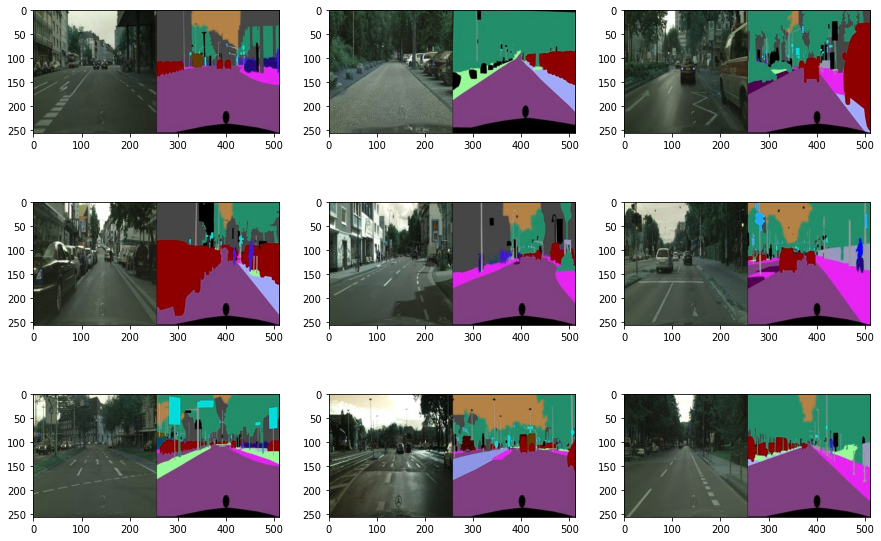

In [3]:
plt.figure(figsize=(15,10))
for i in range(1, 10):
    f = train_dir + os.listdir(train_dir)[np.random.randint(1000)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,3,i)
    plt.imshow(img)

## 2.2 Image Data Dimension

> 위 이미지 데이터를 구성하는 벡터 차원을 확인하는 작업을 진행한다.

In [4]:
f = train_dir + os.listdir(train_dir)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


> 이미지 데이터의 차원을 확인했을때, 512x256 해상도의 컬러 이미지 객체가 생성된 모습을 확인할 수 있다.

## 2.3 Split Images

> 현 데이터셋의 이미지 데이터에는 실제 이미지와 세그먼트 처리가 된 이미지가 합쳐있는 형태이다.<br>
> 모델 학습에는 적합하지 않기에, 두 이미지를 분리하는 사용자 정의 함수를 구현한다. 

### 2.3.1 Create Custom function.

In [5]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, w:, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, :w, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(colored), normalize(sketch)

### 2.3.2 Check The Function

> 이미지를 분할하는 사용자 정의 함수의 기능의 정상작동 여부 확인을 위한 테스트를 진행한다.

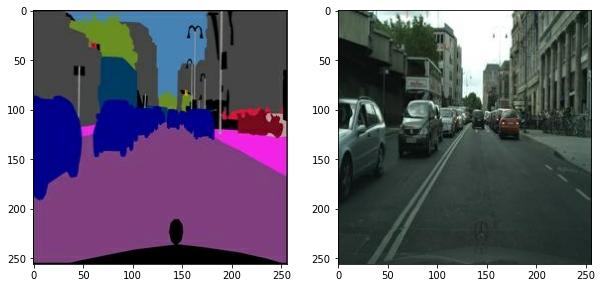

In [6]:
f = train_dir + os.listdir(train_dir)[1]
colored, sketch = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

> 실제 이미지와 세그먼트 이미지가 깔끔하게 잘 분리됨을 확인할 수 있다.

## 2.4 Data Augmentation

> Cityscapes Dataset은 1,000개의 훈련용 데이터를 지원한다.<br>
> 그러나, 1,000개의 데이터는 모델이 충분히 학습하기에는 적은량의 데이터이다.<br>
> 이에, 위 문제점을 보완하기 위하여 원본 데이터를 변형하여 추가 데이터를 생성하는 보강 작업을 진행한다.<br>

### 2.4.1 Create Augmentation Fruntion

> 데이터의 량을 보강하는 기능을 수행하는 Augmentation 함수를 구현한다.<br>
> Augmentation 함수가 수행하는 기능은 아래와 같다.<br><br>
> 1. 세그먼트 이미지와 실제 이미지를 채널 축을 기준으로 연결한다. -> 각 이미지가 3채널일경우 총 6채널이 된다.<br>
> 2. 랜덤값이 0.5(50%) 이하일 경우, REFLECT padding or CONSTANT padding을 가로,세로 채널에 적용한다.<br>
> 3. 이미지를 (256,256,6) 차원 벡터로 재구성한다.<br>
> 4. 랜덤하게 이미지를 가로, 세로로 뒤집는다.<br>
> 5. 랜덤값이 0.5(50%) 이하일 경우, 이미지를 90도 회전한다.

In [7]:
@tf.function()
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

> 이미지 데이터를 보강하는 Augmentation 함수의 기능의 정상작동 여부 확인을 위한 테스트를 진행한다.

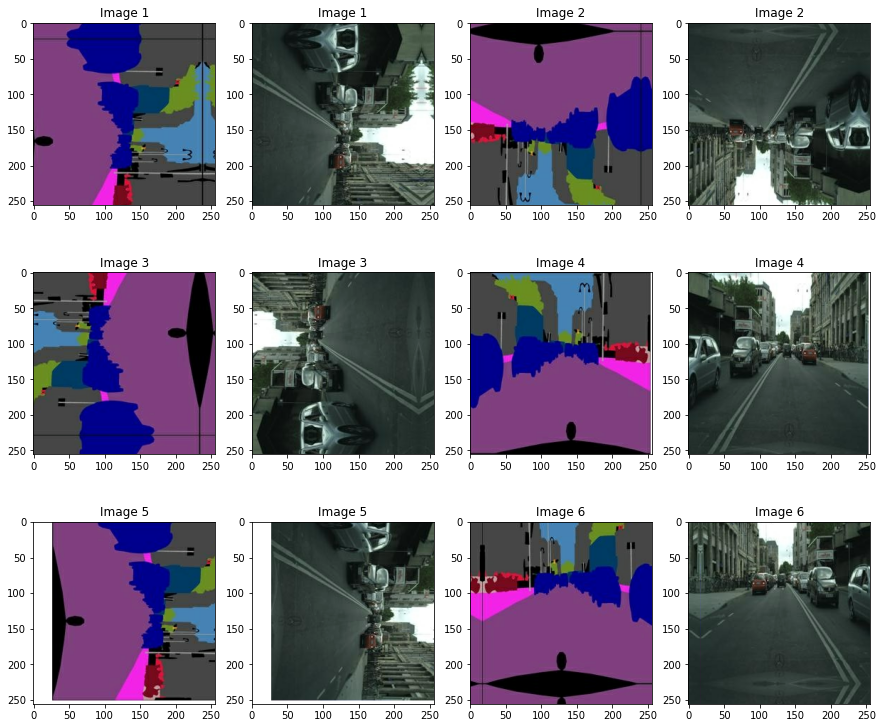

In [8]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

> 위 결과로 Augmentation 함수의 기능이 잘 수행됨을 확인할 수 있다.

## 2.5 Create Dataset For Model

> 위 2.3 ~ 2.4장의 기능을 활용하여 모델 학습을 위한 데이터 세트를 생성하는 작업을 진행한다.<br>
> 이를 위한 사용자 정의 함수를 구현하고 모델을 위한 데이터세트를 생성한다.

In [9]:
def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

In [10]:
train_images = data.Dataset.list_files(train_dir + "*.jpg")
train_images = train_images.map(get_train).shuffle(1000).batch(4)

> 모델의 훈련용 데이터를 생성하는 사용자 정의 함수의 기능의 정상작동 여부 확인을 위한 테스트를 진행한다.

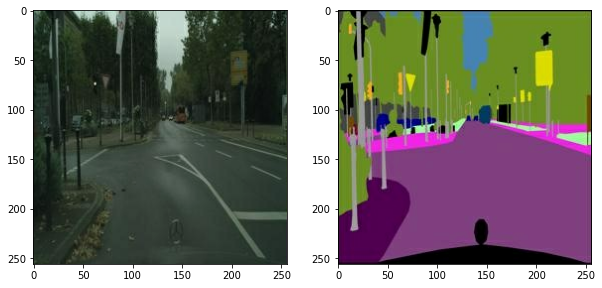

In [11]:
sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

> 위 결과로 데이터 생성 기능을 수행하는 사용자 정의 함수가 잘 동작함을 확인할 수 있다.

# 3. pix2pix Model Design

> Pix2Pix Model은 이미지를 입력값으로, 원하는 다른 형태의 이미지로 변환시킬 수 있는 GAN 모델이다.<br>
> 위 모델을 사용하여 세그먼트(스케치) 이미지를 실제 도로 이미지 데이터로 변환하는 모델을 설계한다.

## 3.1 Create U-Net Generator

> 본 모델의 Generator(생성자)는 Encoder와 Decoder 사이를 skip connection으로 연결한 구조인 U-Net을 사용한다.<br>
> U-Net은 모델의 전체적인 구조가 U자 모양으로 구성되며, 인코더의 출력 값으로 디코터가 이미지의 특징을 추출한다.<br>
> 이는, 저차원 벡터 정보만으로 이미지를 구성한 기존 모델과 달리, U-Net은 같은 레이어 층의 인코더의 출력값<br>
> (상대적 고차원 벡터 정보)를 활용하여 이미지를 구성한다.<br><br>
> P.S : 각 네트워크 7계층 구조와 소프트웨어 테스트 구조를 생각하면 U-Net의 구조를 기억하기 쉽다.

### 3.1.1 Create Encoder and Decoder Layer

> Generator의 기본 구조인 Encoder layer와 Decoder layer을 구현하는 작업을 진행한다.

In [12]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

### 3.1.2 Create Generator

> U-Net 구조를 가진 Generator 객체를 생성하는 함수를 구현한다.

In [13]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

> 위 함수를 활용하여 U-Net Generator 객체를 생성후 Generator 모델의 구조를 확인한다.

In [14]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

> 총 54,425,856개의 파라미터 중 54,414,976개의 파라미터가 학습 대상임을 확인할 수 있다.

## 3.2 Create Discriminator

> 본 모델(pix2pix)의 Discriminator(판별자)는 기존 GAN과 달리 하나의 출력값(True, False)이 아닌, 여러 정보가 담긴 행렬 형태로 출력한다.
> 즉, 본 모델의 출력값은 이미지 데이터의 각 픽셀 위치 값에 대한 True, False를 출력함을 의미힌다.<br>
> 이로써 생성자는 Fake 판정을 받는 이미지 데이터의 픽셀 값을 수정하는데 가중치를 더함으로써 효율적인 학습을 가능하게 한다.

### 3.2.1 Discriminator Block Layer

> Discriminator의 기본 구조을 구현하는 작업을 진행한다.

In [15]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x

### 3.2.2 Create Discriminator

> U-Net 구조를 가진 Discriminator 객체를 생성하는 함수를 구현한다.

In [16]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        
        self.sigmoid = layers.Activation("sigmoid")
        
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

> 위 함수를 활용하여 U-Net Discriminator 객체를 생성후 Discriminator 모델의 구조를 확인한다.

In [17]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

> 총 2,770,432개의 파라미터 중 2,768,640개의 파라미터가 학습 대상임을 확인할 수 있다.

# 4. Model Train

> 본 4장에서는 Pix2Pix 모델을 학습하는 과정을 기술한다.<br>
> 모델 학습을 위해 Hyper parameter을 설정하고 모델 학습을 진행한다.

## 4.1 Setting Loss Function

> 본 4.1장에서는 Generator과 Discriminator의 손실함수를 정의한다.<br>

<br>

> Generator의 손실함수는 fake_output, real_output, fake_disc 3가지의 값을 입력받는다.<br>
> 1. fake_disc는 Generator가 생성한 fake image를 Discriminator에 입력했을때의 출력 값이다.<br>
> 2. 가짜 이미지(fake_output)와 실제 이미지(real_output)은, L1 손실을 계산하기 위해 두 이미지 사이의 MAE(Mean Absolute Error)를 계산한다.<br>

<br>

> Discriminator의 손실함수는 fake_disc, real_disc 2가지의 값을 입력받는다.<br>
> real_disc는 "1"로 채워진 벡터를 비교하며, fake_disc는 "0"으로 채워진 벡터와 비교한다.

In [18]:
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

## 4.2 Setting Optimizers

> 본 4.2장에서는 모델의 옵티마이저를 정의하며, Pix2Pix의 논문과 동일한 Adam으로 설정한다.

In [35]:
gene_opt = optimizers.Adam(1e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(1e-4, beta_1=.5, beta_2=.999)

## 4.3 Setting Train Step

> 본 4.3장에서는 모델의 학습 방법을 설정한다.<br>
> 본 모델에서 학습 시 하나의 배치 크기만큼 데이터를 입력했을 때 가중치를 1회 업데이트하도록 사용자 정의 함수를 구현한다.

In [36]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:

        fake_colored = generator(sketch, training=True)
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)

        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss)
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

## 4.4 Model Train

> 본 4.4장에서는 위 4.1~4.3에서 설정한 하이퍼 파라미터와 3장에서 구현한 U-Net model을 활용하여 모델을 학습하는 과정을 기술한다.

> GAN 모델에 사용할 U-Net Generator과 Discriminator 객체를 생성하고 훈련 횟수는 300회로 지정한다.

In [21]:
generator = UNetGenerator()
discriminator = Discriminator()

EPOCHS = 300

> 아래 코드를 활용하여 모델 학습을 진행한다. 이때, 50회 훈련 마다 손실도를 출력한다.

In [22]:
for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
        
        if (i+1) % 250 == 0 and (epoch) % 50 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[25] - STEP[250]                     
Generator_loss:1.5573                     
L1_loss:0.1575                     
Discriminator_loss:0.4876

EPOCH[50] - STEP[250]                     
Generator_loss:3.2532                     
L1_loss:0.1256                     
Discriminator_loss:1.4132

EPOCH[75] - STEP[250]                     
Generator_loss:5.0361                     
L1_loss:0.1548                     
Discriminator_loss:1.6479

EPOCH[100] - STEP[250]                     
Generator_loss:4.1712                     
L1_loss:0.1387                     
Discriminator_loss:0.0660

EPOCH[125] - STEP[250]                     
Generator_loss:5.8406                     
L1_loss:0.1302                     
Discriminator_loss:0.1566

EPOCH[150] - STEP[250]                     
Generator_loss:6.5962                     
L1_loss:0.1481                     
Discriminator_loss:0.0144

EPOCH[175] - STEP[250]                     
Generator_loss:2.7910                     
L1_loss:0.1086  

# 5. Result

> 본 5장에서는 학습된 모델을 활용하여 검증용 데이터셋을 기반으로 새로운 도로 이미지를 생성하는 과정을 기술한다.

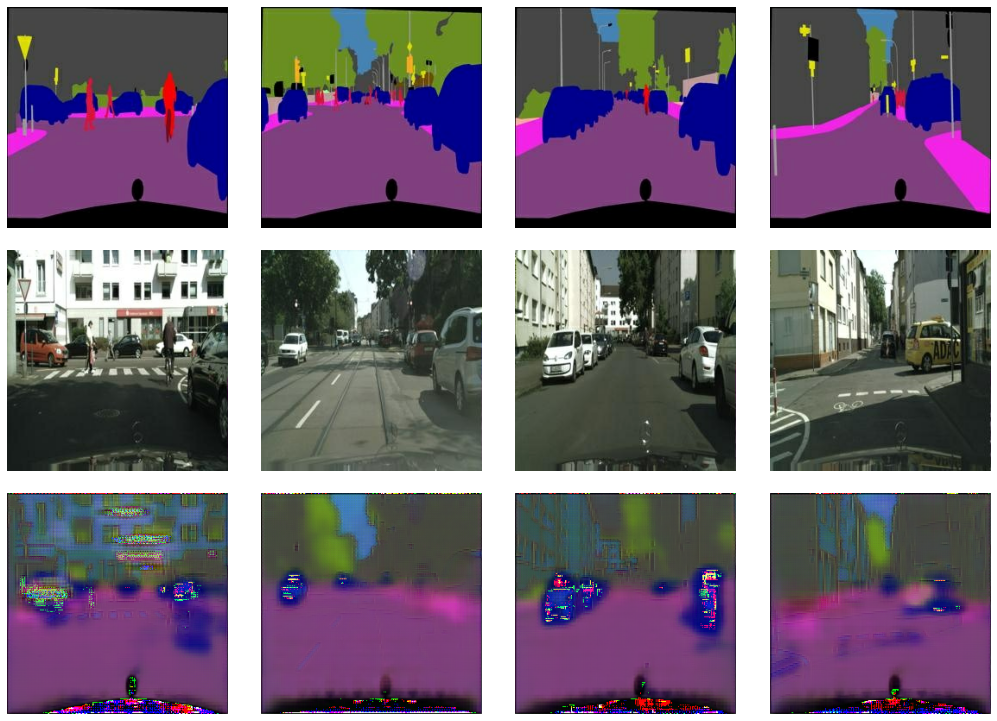

In [42]:
for i in range(1,5):
    f = val_dir + os.listdir(val_dir)[i]
    colored, sketch = load_img(f)

    pred = generator(tf.expand_dims(sketch, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
    plt.subplot(1,3,2); plt.imshow(denormalize(colored))
    plt.subplot(1,3,3); plt.imshow(pred[0])

> [E-11]모델을 300회 훈련한 결과는 위 그림과 같다.<br>
> 절대적인 훈련량이 부족하여 색 재현은 실물 사진과 같이 하지 못했다.<br>
> 그러나, 스케치 사진을 주었을때 알맞은 도로를 그리려야하는 요구 조건은 달성한것을 확인할 수 있다.<br>
> <br>
> 1번 생성 이미지는, 사람이 차 가까이 있는 스케치 이미지를 바탕으로, 횡단보도를 그린 모습을 확인할 수 있다.<br>
> 2번 생성 이미지는, 도로가 넓은 스케치 이미지를 주었을 때, 차선을 그린 모습을 확인할 수 있다.<br>
> 3번 생성 이미지는, 도로가 좁은 스케치 이미지를 주었을 때, 차선을 그리지 않은 모습을 확인할 수 있다.<br>
> 4번 생성 이미지는, 도로가 매우 좁은 스케치 이미지를 주었을 때, 바닥에 무언가를 그리려는 파란색 픽셀을 확인할 수 있다.

# 후기

> GAN은 학습 횟수가 많기에, 옵티마이저의 학습률에 영향이 클것이라 생각하여, 옵티마이저를 튜닝하며 여러 모델을 훈련해보았습니다.<br>
> Adam의 학습률을 높일수록 Discriminator의 판별 성능 너무 좋아져, loss_rate가 0에 가까워지는 모습을 보여주었습니다.<br>
> 이에, Generator의 loss_rate는 9 이상의 높은 오류율을 보이며 성능이 좋아지지 않았습니다.<br>
> 그래서 반대로 Adam의 학습율을 낮추자, Discriminator의 loss_rate는 0.4 ~ 0.7 사이의 값을 보여주며 준수한 수치를 보여주었습니다.<br>
> Generator의 loss_rate또한 0.6 ~ 1.1 사이의 값을 보여주어 이번 모델은 좋은 결과를 출력해줄것이라 기대했습니다.<br>
> 그러나, 학습률이 너무 낮아 학습 자체가 안되어 좋은 결과를 보여주지 못했습니다.<br>
> <br>
> 이에, 좋은 결과를 얻기 위해 500회 이상 ~1000회의 고반복 훈련을 기획하고 이에 맞춰 설계 후 훈련을 진행했습니다.<br>
> 그러나 LMS의 로그인 세션을 연장해주어도 멋대로 실습환경을 재구성하면서 기존 학습 중이던 주피터 노트북과의 커널 연결이 해제되는 상황이 지속되며, 학습 중인 모델이 날아가는 사고가 많이 발생했습니다.<br>
> 결국, 최소한의 결과를 출력하기 위한 300회밖에 반복하지 못한 모델을 최종 제출하게 되어 아쉬움이 큽니다.